In [1]:
import numpy as np
from numpy.random import default_rng
import math
import time

rng = default_rng()

def LCB_index(mean, Nt, t):
    return (mean/Nt) - (3*math.log(t)/(2*Nt))**0.5

#K: number of arms
#p: binomial distributions
#N: number of samples to draw
def LCB(K, p, T, dist):
  if (K > T):
    print('LCB error: K must be <= T')
    exit()
  draw = dist
  #Create (3,K) array where
  #Col 0: Empirical mean 
  #Col 1: Nt
  data = np.zeros(shape=(2,K), dtype=float) 
  
  #Initial data structure
  data[0,:] = np.array(list(map(draw,p))) 
  data[1,:] = 1 # Nt = 1 for all actions
  #index_func = lambda mean,Nt,t: (mean/Nt) + (3*math.log(t)/(2*Nt))**0.5
  acc_cost = np.zeros(T) 
  acc_reg = np.zeros(T) 
  opt_p = np.min(p)

  # Initial K actions
  for a in range(K):
    acc_cost[a] = data[0,a] + acc_cost[a-1] if a > 0 else data[0,0]
    acc_reg[a] = acc_cost[a] - opt_p * a
  indexes = np.asarray(list(map(LCB_index,data[0,:], data[1,:], np.zeros(K)+K))) #Initial LCB for all actions
  # Actions K+1 to T
  for t in range(K, T):
    a = np.argmin(indexes)
    cost = draw(p[a])
    data[:,a] += np.array([cost, 1]) #add cost and increment Nt
    indexes[a] = LCB_index(data[0,a], data[1,a], t+1)
    acc_cost[t] = cost + acc_cost[t-1]
    acc_reg[t] = acc_cost[t] - opt_p * t

  return (acc_reg, data[1,:])

def TS(K,p,T,dist):
  #Data contains the following for each arm:
  #Col 1: Accumulated costs
  #Col 2: Nt
  data = np.zeros(shape=(2,K))
  draw = dist 
  draw_beta = lambda costs, Nt: rng.beta(costs+1, Nt-costs+1)
  acc_cost = np.zeros(T) 
  acc_reg = np.zeros(T)
  opt_p = np.min(p)
  for t in range(T):
    samples = np.asarray(list(
                  map(draw_beta, data[0], data[1]))) 
    a = np.argmin(samples)
    cost = draw(p[a])
    data[:,a] += np.array([cost, 1])
    acc_cost[t] = cost+acc_cost[t-1] if t > 0 else cost
    acc_reg[t] = acc_cost[t] - opt_p * t 
 
  return (acc_reg, data[1,:])

In [2]:
import matplotlib.pyplot as plt
draw = lambda p: 1 if rng.random() < p else 0
T = 10000
N = 100
#p = np.array([0.7,0.5,0.6,0.4,0.45,0.1]) #Exp A
p = np.array([0.71,0.7,0.69,0.68,0.67,0.66]) #Exp B
K = len(p)
c_lcb = np.zeros((T,N))
Nt_lcb = np.zeros((K,N))
c_ts = np.zeros((T,N))
Nt_ts = np.zeros((K,N))
worst = np.arange(T) * np.max(p) - np.arange(T) * np.min(p)

for i in range(N):
  a,b = LCB(K,p,T,draw)
  c_lcb[:,i] = a
  Nt_lcb[:,i] = b
  a,b = TS(K,p,T,draw)
  c_ts[:,i] = a
  Nt_ts[:,i] = b

lcb_means = np.mean(c_lcb, axis=1)
lcb_vars = np.var(c_lcb, axis=1)
lcb_std = lcb_vars**0.5
ts_means = np.mean(c_ts, axis=1)
ts_vars = np.var(c_ts, axis=1)
ts_std = ts_vars**0.5


#Average run
Nt_lcb = np.mean(Nt_lcb, axis=1)
Nt_ts = np.mean(Nt_ts, axis=1)

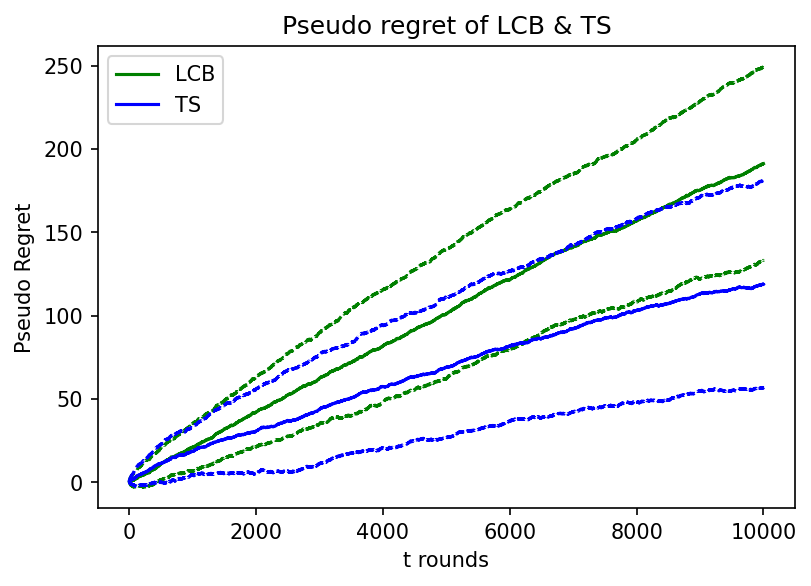

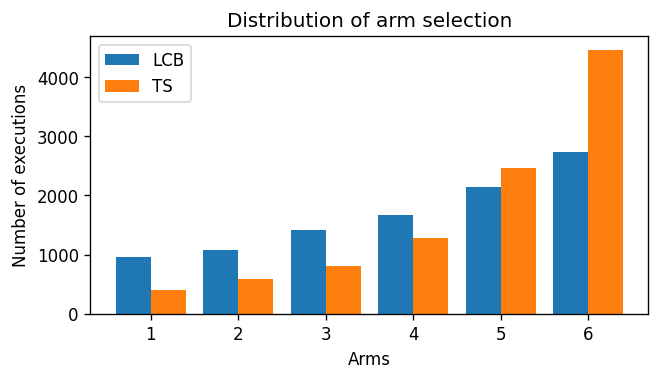

In [3]:
t = np.arange(T) + 1
plt.figure(1, figsize=(6,4), dpi=150)
plt.plot(t,lcb_means, label='LCB', color='g')
plt.plot(t,lcb_means-lcb_std, '--', color='g')
plt.plot(t,lcb_means+lcb_std, '--', color='g')
plt.plot(t,ts_means, label='TS', color='b')
plt.plot(t,ts_means-ts_std, '--', color='b')
plt.plot(t,ts_means+ts_std, '--', color='b')
#plt.plot(t,worst, label='Worst case', color='orange')
plt.xlabel('t rounds')
plt.ylabel('Pseudo Regret')
plt.title('Pseudo regret of LCB & TS')
plt.legend(loc='upper left')
#plt.show()

plt.figure(2, figsize=(6,3), dpi=120)
plt.title('Distribution of arm selection')
counts = np.arange(K)
labels =  np.asarray(list(map(str,counts+1)))
plt.bar(counts,Nt_lcb,label='LCB',tick_label=labels,align='edge',width=-0.4)
plt.bar(counts,Nt_ts,label='TS',tick_label=labels,align='edge',width=0.4)
plt.xlabel('Arms')
plt.ylabel('Number of executions')
plt.legend(loc='upper left')
plt.show()